# Predicting the Stock Market

In this project, we will work with data from the S&P500 Index. We will use historical data to make predictions about future behavior. 


## Data
Our data covers the years 1950 to 2015. Each row in the file contains a daily record of the price of the S&P500 index. The columns in the dataset are:

- ```Date``` -- The date of the record.
- ```Open``` -- The opening price of the day (when trading starts).
- ```High``` -- The highest trade price during the day.
- ```Low``` -- The lowest trade price during the day.
- ```Close``` -- The closing price for the day (when trading is finished).
- ```Volume``` -- The number of shares traded.
- ```Adj Close``` -- The daily closing price, adjusted retroactively to include any corporate actions.

## Goal
We will train the predictive model we build using data from 1950-2012 and make predictions from 2013-2015. 



In [67]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    linewidth=4
    )


%matplotlib inline


In [68]:
index = pd.read_csv('sphist.csv')

In [69]:
index.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [70]:
index.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

The ```Date``` column is an object type. Let's go ahead and convert it to a ```datetime``` type. This will allow us to more easily extract specific date ranges.

In [71]:
index['Date'] = pd.to_datetime(index['Date'])

In [72]:
index.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

We also note that dates are sorted reverse chronologically, starting with the last day (2015) and moving towards earlier dates. Let's sort this in ascending order instead.

In [73]:
index.sort_values(by='Date',ascending=True,inplace=True)

In [74]:
index.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999


## Generating Indicators

Since we have time series data, let's generate a few indicators to make our model more accurate. We'll create a few of these, but will need to be careful. Stock market data is sequential and each observation comes a day after the previous observation. Thus, the observations are not all independent. We don't want to inject future knowledge into past row when we train and predict. For example, when creating an average price from the last 5 days we do not want to include the current day in that average. We'll create the following indicators:

- average closing price from the past 5 days
- average closing price from the past 30 days
- average closing price from the past 365 days
- ratio between the average price from the past 5 days and the average price from the past 365 days
- average volume from the past 5 days
- average volume from the past 30 days
- average volume from the past 365 days
- standard deviation of the closing price from the past 5 days
- standard deviation of the closing price from the past 30 days
- standard deviation of the closing price from the past 365 days
- standard deviation of the volume from the past 5 days
- standard deviation of the volume from the past 30 days
- standard deviation of the volume from the past 365 days


We will use the rolling function in pandas to accopmlish this. However, the rolling mean will use the current days price, so we need to reindex the series to shift all the values forward one day. 

In [75]:
index['avg_close_5'] = index.Close.rolling(5).mean().shift(periods=1)
index['avg_close_30'] = index.Close.rolling(30).mean().shift(periods=1)
index['avg_close_365'] = index.Close.rolling(365).mean().shift(periods=1)
index['avg_volume_5'] = index.Volume.rolling(5).mean().shift(periods=1)
index['avg_volume_30'] = index.Volume.rolling(30).mean().shift(periods=1)
index['avg_volume_365'] = index.Volume.rolling(365).mean().shift(periods=1)

index['std_close_5'] = index.Close.rolling(5).std().shift(periods=1)
index['std_close_30'] = index.Close.rolling(30).std().shift(periods=1)
index['std_close_365'] = index.Close.rolling(365).std().shift(periods=1)
index['std_volume_5'] = index.Volume.rolling(5).std().shift(periods=1)
index['std_volume_30'] = index.Volume.rolling(30).std().shift(periods=1)
index['std_volume_365'] = index.Volume.rolling(365).std().shift(periods=1)

index.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,avg_volume_5,avg_volume_30,avg_volume_365,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,2046000.0,NaN,NaN,0.157956,NaN,NaN,529650.828377,NaN,NaN
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,2226000.0,NaN,NaN,0.089051,NaN,NaN,298043.620968,NaN,NaN
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,2374000.0,NaN,NaN,0.067602,NaN,NaN,272084.545684,NaN,NaN
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,2458000.0,NaN,NaN,0.134796,NaN,NaN,382452.611444,NaN,NaN
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,2722000.0,NaN,NaN,0.196545,NaN,NaN,446172.612337,NaN,NaN


To create our ratio, we will use the np.where function because we need to easily account for the NaNs.

In [76]:
index['avg_close_ratio'] = np.where(index['avg_close_365'] != np.nan, index['avg_close_5'] / index['avg_close_365'], np.nan)
index['avg_volume_ratio'] = np.where(index['avg_volume_365'] != np.nan, index['avg_volume_5'] / index['avg_volume_365'], np.nan)


## Splitting Up the Data

Since we generated some indicators, there are some rows where there is now missing data. We're going to drop these data. While this means we'll drop about a years worth of data, because of the 365 day average, the training set is large enough that this is only about 1.5% of the total data.

In [77]:
index.dropna(axis=0,inplace=True)
index.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,avg_volume_30,avg_volume_365,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,...,1.707667e+06,1.989479e+06,0.256223,0.473595,1.790253,142232.204511,1.566790e+06,772310.649463,1.120954,0.601162
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,...,1.691667e+06,1.989041e+06,0.213659,0.444648,1.789307,148425.065269,1.570585e+06,772771.102512,1.125246,0.591240
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,...,1.675667e+06,1.986932e+06,0.092574,0.411452,1.788613,138816.425541,1.573993e+06,774092.100761,1.128142,0.597907
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,...,1.647000e+06,1.982959e+06,0.115108,0.368514,1.787659,126767.503722,1.576465e+06,774914.749625,1.126757,0.578933
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,...,1.636333e+06,1.981123e+06,0.204132,0.329130,1.786038,113666.177907,1.577456e+06,775643.723180,1.121008,0.576441


Now we are ready to split the data into the training set and the testing set. Dates before 2013-01-01 will go into the training set and dates after that will go into the testing set. 

In [78]:
train = index[index['Date'] < datetime(year=2013,month=1,day=1)]
test = index[index['Date'] >= datetime(year=2013,month=1,day=1)]

In [79]:
train.shape

(15486, 21)

In [80]:
train.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,avg_volume_30,avg_volume_365,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio
743,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,1437.360010,1405.926001,1326.114028,...,3.461864e+09,3.886189e+09,7.622009,24.746569,89.830647,6.990482e+08,6.520010e+08,7.626629e+08,1.083889,1.057251
742,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,1436.620019,1407.486336,1326.412494,...,3.381918e+09,3.878488e+09,8.589693,24.520427,89.983530,1.477523e+09,7.656156e+08,7.749962e+08,1.083087,0.945561
741,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1408.813000,1326.716494,...,3.372501e+09,3.872807e+09,9.058684,24.055972,90.111444,1.535105e+09,7.776211e+08,7.790566e+08,1.078775,0.842775
740,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,1427.685986,1410.265332,1326.995836,...,3.351655e+09,3.868936e+09,10.208568,23.215373,90.236516,1.502584e+09,7.836766e+08,7.807206e+08,1.075878,0.789876
739,2012-12-31,1402.430054,1426.739990,1398.109985,1426.189941,3.204330e+09,1426.189941,1419.434009,1411.830001,1327.261562,...,3.295561e+09,3.864302e+09,10.701861,20.858522,90.315637,1.475799e+09,7.877764e+08,7.842493e+08,1.069446,0.725617


In [81]:
test.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,avg_volume_30,avg_volume_365,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055,...,3.271409e+09,3.861288e+09,9.820801,17.834740,90.463948,7.366851e+08,7.787457e+08,7.846668e+08,1.068629,0.621305
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247,...,3.276632e+09,3.862480e+09,22.261321,16.852563,90.738976,7.674944e+08,7.846227e+08,7.848543e+08,1.073714,0.774053
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877,...,3.291797e+09,3.859719e+09,26.274326,17.470824,90.995857,7.224721e+08,7.909560e+08,7.831860e+08,1.079412,0.854649
735,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617,...,3.299034e+09,3.859449e+09,27.945242,18.339803,91.279049,6.733364e+08,7.911482e+08,7.833194e+08,1.086423,0.885496
734,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603,...,3.320297e+09,3.858814e+09,16.453319,18.678333,91.544368,4.153739e+08,7.820986e+08,7.836758e+08,1.095093,0.931163


## Making Predictions

We are now ready to build our model and start testing. 

In [82]:
lr = LinearRegression()

features = ['avg_close_5','avg_close_30','avg_close_365','avg_close_ratio',
           'avg_volume_5','avg_volume_30','avg_volume_365','avg_volume_ratio',
           'std_close_5','std_close_30','std_close_365',
           'std_volume_5','std_volume_30','std_volume_365']
target = 'Close'

lr.fit(train[features],train[target])

predictions = lr.predict(test[features])

mae = mean_absolute_error(test[target],predictions)
print(mae)



16.162852213198637


Let's evaluate removing one of these features before we consider adding other indicators.

In [83]:
mae_dict = {}
features = ['avg_close_5','avg_close_30','avg_close_365','avg_close_ratio',
           'avg_volume_5','avg_volume_30','avg_volume_365','avg_volume_ratio',
           'std_close_5','std_close_30','std_close_365',
           'std_volume_5','std_volume_30','std_volume_365']

target = 'Close'

for x in features:
    temp_features = features.copy()
    temp_features.remove(x)
    lr.fit(train[temp_features],train[target])
    temp_predictions = lr.predict(test[temp_features])
    temp_mae = mean_absolute_error(test[target],temp_predictions)
    dict_key = 'no_' + x 
    mae_dict[dict_key] = temp_mae
    
print(pd.DataFrame.from_dict(mae_dict,orient='index'))

                             0
no_avg_close_5       25.400508
no_avg_close_30      16.123864
no_avg_close_365     16.163574
no_avg_close_ratio   16.161404
no_avg_volume_5      16.166430
no_avg_volume_30     16.194892
no_avg_volume_365    16.354098
no_avg_volume_ratio  16.158091
no_std_close_5       16.086072
no_std_close_30      16.091747
no_std_close_365     16.221088
no_std_volume_5      16.047267
no_std_volume_30     16.053708
no_std_volume_365    16.332613


The mean absolute error is surprising insensitive to dropping most of these columns with the exception of ```avg_close_5```, the average closing from the previous 5 days. Dropping the other columns produces very little change.

## Visualize the Results


In [84]:
test_copy = test.copy() # copying so we don't accidently change the original if we re-run anything
test_copy['predicted_close'] = predictions
test_copy['difference'] = test_copy['Close'] - test_copy['predicted_close']

In [85]:
test_copy.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio,predicted_close,difference
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055,...,9.820801,17.834740,90.463948,7.366851e+08,7.787457e+08,7.846668e+08,1.068629,0.621305,1421.006699,41.413345
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247,...,22.261321,16.852563,90.738976,7.674944e+08,7.846227e+08,7.848543e+08,1.073714,0.774053,1425.625399,33.744596
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877,...,26.274326,17.470824,90.995857,7.224721e+08,7.909560e+08,7.831860e+08,1.079412,0.854649,1432.721444,33.748527
735,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617,...,27.945242,18.339803,91.279049,6.733364e+08,7.911482e+08,7.833194e+08,1.086423,0.885496,1442.337885,19.552130
734,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603,...,16.453319,18.678333,91.544368,4.153739e+08,7.820986e+08,7.836758e+08,1.095093,0.931163,1455.493634,1.656390


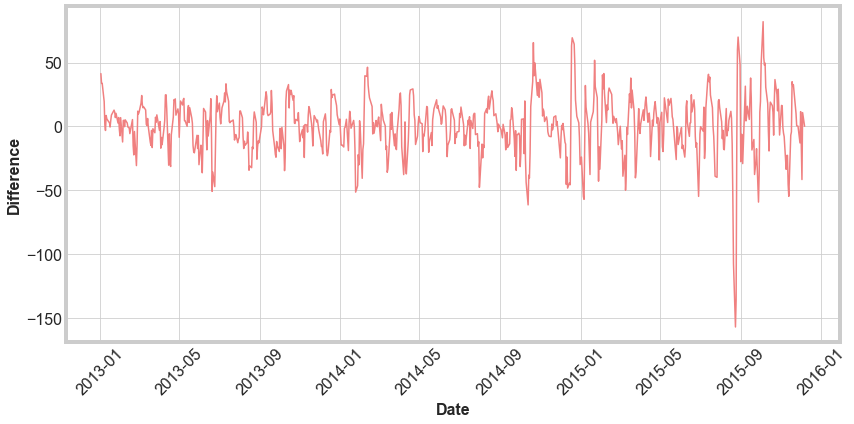

In [86]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date',y='difference',data=test_copy,color='lightcoral')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Difference',fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.show()

## Predict Day-by-Day

To improve our predictions, we could predict the next day, then use the closing information to predict the following day, and so on. Let's write a function that will allow us to do this, so we can compare to the predictions we just made.

In [87]:
index.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,avg_volume_30,avg_volume_365,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726,...,1.707667e+06,1.989479e+06,0.256223,0.473595,1.790253,142232.204511,1.566790e+06,772310.649463,1.120954,0.601162
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411,...,1.691667e+06,1.989041e+06,0.213659,0.444648,1.789307,148425.065269,1.570585e+06,772771.102512,1.125246,0.591240
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274,...,1.675667e+06,1.986932e+06,0.092574,0.411452,1.788613,138816.425541,1.573993e+06,774092.100761,1.128142,0.597907
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562,...,1.647000e+06,1.982959e+06,0.115108,0.368514,1.787659,126767.503722,1.576465e+06,774914.749625,1.126757,0.578933
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082,...,1.636333e+06,1.981123e+06,0.204132,0.329130,1.786038,113666.177907,1.577456e+06,775643.723180,1.121008,0.576441


In [88]:

features = ['avg_close_5','avg_close_30','avg_close_365','avg_close_ratio',
           'avg_volume_5','avg_volume_30','avg_volume_365','avg_volume_ratio',
           'std_close_5','std_close_30','std_close_365',
           'std_volume_5','std_volume_30','std_volume_365']
target = 'Close'

comparison_df = pd.DataFrame

cols = ['Date', 'Closing', 'Prediction']
lst = []


for indices in range(len(index)):
    lr = LinearRegression()
    if index['Date'].iloc[indices] >= datetime(year=2013,month=1,day=2):
        training_df = index.iloc[:indices]
        lr.fit(training_df[features],training_df[target])
        prediction_array = np.array([index[features].iloc[indices]]) # convert to array so we have numerical dtypes
        new_prediction = lr.predict(prediction_array)
        lst.append([index['Date'].iloc[indices],index['Close'].iloc[indices],new_prediction[0]])


comparison_df = pd.DataFrame(lst,columns=cols)
comparison_df.head()

,Date,Closing,Prediction
0,2013-01-02,1462.420044,1421.006699
1,2013-01-03,1459.369995,1425.740900
2,2013-01-04,1466.469971,1432.939366
3,2013-01-07,1461.890015,1442.688916
4,2013-01-08,1457.150024,1455.769579


In [89]:
comparison_df['difference'] = comparison_df['Closing'] - comparison_df['Prediction']
comparison_df.head()

,Date,Closing,Prediction,difference
0,2013-01-02,1462.420044,1421.006699,41.413345
1,2013-01-03,1459.369995,1425.740900,33.629095
2,2013-01-04,1466.469971,1432.939366,33.530605
3,2013-01-07,1461.890015,1442.688916,19.201099
4,2013-01-08,1457.150024,1455.769579,1.380445


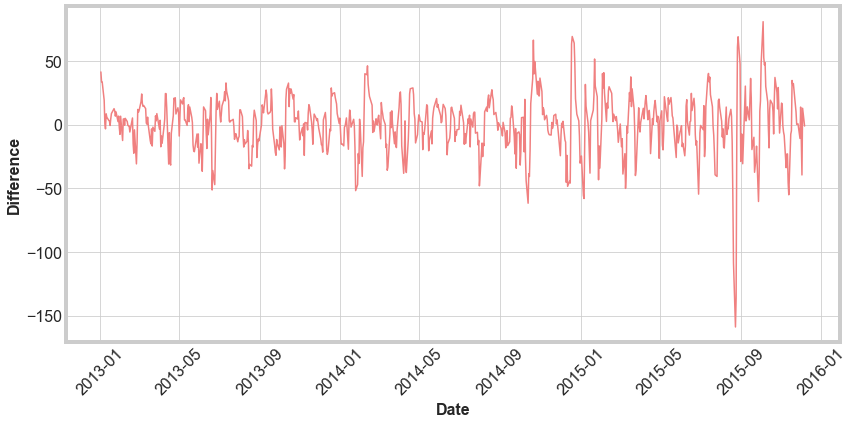

In [90]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date',y='difference',data=comparison_df,color='lightcoral')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Difference',fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.show()

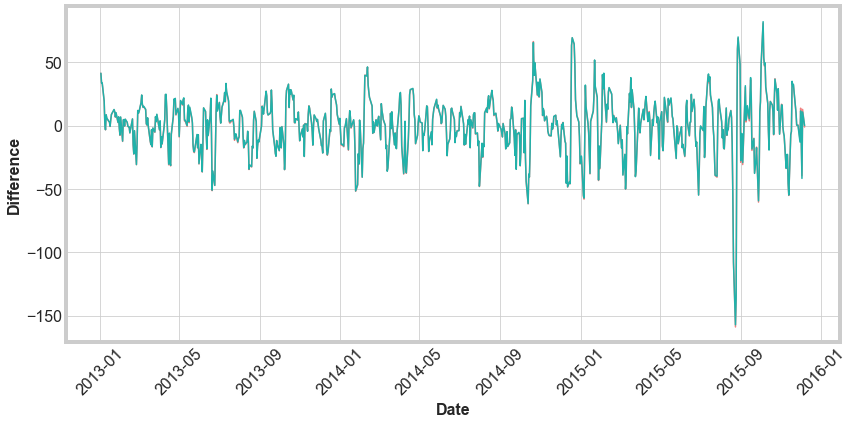

In [91]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date',y='difference',data=comparison_df,color='lightcoral')
sns.lineplot(x='Date',y='difference',data=test_copy,color='lightseagreen')

plt.xlabel('Date',fontsize=16)
plt.ylabel('Difference',fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.show()

In [92]:
comparison_df.head()

,Date,Closing,Prediction,difference
0,2013-01-02,1462.420044,1421.006699,41.413345
1,2013-01-03,1459.369995,1425.740900,33.629095
2,2013-01-04,1466.469971,1432.939366,33.530605
3,2013-01-07,1461.890015,1442.688916,19.201099
4,2013-01-08,1457.150024,1455.769579,1.380445


In [93]:
test_copy.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio,predicted_close,difference
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055,...,9.820801,17.834740,90.463948,7.366851e+08,7.787457e+08,7.846668e+08,1.068629,0.621305,1421.006699,41.413345
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247,...,22.261321,16.852563,90.738976,7.674944e+08,7.846227e+08,7.848543e+08,1.073714,0.774053,1425.625399,33.744596
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877,...,26.274326,17.470824,90.995857,7.224721e+08,7.909560e+08,7.831860e+08,1.079412,0.854649,1432.721444,33.748527
735,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617,...,27.945242,18.339803,91.279049,6.733364e+08,7.911482e+08,7.833194e+08,1.086423,0.885496,1442.337885,19.552130
734,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603,...,16.453319,18.678333,91.544368,4.153739e+08,7.820986e+08,7.836758e+08,1.095093,0.931163,1455.493634,1.656390


In [94]:
test_copy[test_copy['Date'] == datetime(year=2013,month=1,day=2)]

,Date,Open,High,Low,Close,Volume,Adj Close,avg_close_5,avg_close_30,avg_close_365,...,std_close_5,std_close_30,std_close_365,std_volume_5,std_volume_30,std_volume_365,avg_close_ratio,avg_volume_ratio,predicted_close,difference
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055,...,9.820801,17.83474,90.463948,7.366851e+08,7.787457e+08,7.846668e+08,1.068629,0.621305,1421.006699,41.413345
